In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import ttest_ind
import sys
import torch
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from utils import numpy_torch_conversion

plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

# Functions

In [3]:
def rnn(t, x, W, tau, g):
    return (1/tau)*(-x + g*W @ np.tanh(x))

# -I + dt*np.multiply(W_eff, 1 - np.tanh(x[t - 1])**2)

def rnn_jacobian(x, W, g, tau, dt, N, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
    x = numpy_torch_conversion(x, use_torch, device, dtype)
    W = numpy_torch_conversion(W, use_torch, device, dtype)
    if use_torch:
        I = torch.eye(N).type(dtype).to(device)
        if len(x.shape) == 1:
            return I + (dt/tau)*(-I + (g*W @ torch.diag(1 - torch.tanh(x)**2)))
        else:
            return I.unsqueeze(0) + (dt/tau)*(-I.unsqueeze(0) + (g*W*((1 - torch.tanh(x)**2).unsqueeze(1))))
    else:
        if len(x.shape) == 1:
            return np.eye(N) + (dt/tau)*(-np.eye(N) + (g*W @ np.diag(1 - np.tanh(x)**2)))
        else:
            print((1 - np.tanh(x)**2)[:, np.newaxis].shape)
            return np.eye(N)[np.newaxis] + (dt/tau)*(-np.eye(N)[np.newaxis] + (g*W*(1 - np.tanh(x)**2)[:, np.newaxis]))
        
def compute_lyaps(Js, dt=1, k=None, worker_num=None, message_queue=None, verbose=False):
    T, n = Js.shape[0], Js.shape[1]
    old_Q = np.eye(n)
    if k is None:
        k = n
    old_Q = old_Q[:, :k]
    lexp = np.zeros(k)
    lexp_counts = np.zeros(k)
    for t in tqdm(range(T), disable=not verbose):
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

        if message_queue is not None:
            message_queue.put((worker_num, "task complete", "DEBUG"))
    
    return np.divide(lexp, lexp_counts)*(1/dt)

def estimate_stability_using_particle(
    js: np.ndarray, p: int, test_eigenvectors=False
) -> np.ndarray:

    """Estimate maximal lyapunov exponent given a sequence of Jacobians using the technique of ___.
    Push a random unit vector through the sequence and measure the deformation."

    Args:
        js (np.ndarray): Sequence of Jacobians, stored in a multi-dimensional array.
        p (int): Number of random unit vectors to  use.

    Returns:
        lams: p-dimensional array containing estimates of maximal Lyapunov exponent.
    """

    K, N = js.shape[0], js.shape[1]

    # generate p vectors on the unit sphere in R^n
    U = np.random.randn(N, p)
    U /= np.linalg.norm(U, axis=0)

    if test_eigenvectors:
        # generate p vectors along the eigenvectors of js[0]
        eig_vals, eig_vecs = np.linalg.eig(js[0])
        # ind_max_eig = np.argmax(np.abs(eig_vals))
        ind_max_eig = np.argmin(np.abs(eig_vals))
        leading_eig_vec = np.real(eig_vecs[:, ind_max_eig])
        random_scalings = np.random.normal(0, 1, p)
        U = leading_eig_vec[:, None] * random_scalings + np.random.normal(
            0, 0.001, (N, p)
        )
        U /= np.linalg.norm(U, axis=0)

    # preallocate memory for lyapunov exponents
    lams = np.zeros(p)

    for k in range(K):

        # push U through jacobian at time t
        U = js[k] @ U

        # measure deformation and store log
        lams += np.log(np.linalg.norm(U, axis=0))

        # renormalize U
        U /= np.linalg.norm(U, axis=0)

    # average by number time steps to get lyapunov exponent estimates
    lams /= K

    return lams

# Simulate Signals

In [4]:
# setup list of gains
# g_vals = np.linspace(0.8, 1.3, 5)
# g_vals = [0.8, 0.9, 1, 1.1, 1.2, 1.3]
# inhibition_scales = np.linspace(0.5, 2, 5)
# inhibition_scales = [0.5, 0.75, 1, 1.25, 1.5, 2]
g_vals = [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
inhibition_scales = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

In [5]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/increasing_inhibition'
os.makedirs(save_dir, exist_ok=True)

In [6]:
# simulate a bunch of networks with scale inhibition

NUM_RUNS = 10

N = 512
T = 10000
dt = 0.001
tau = 0.01
def g_dW(x, scale=1):
    return scale

signals = {}

for run_num in tqdm(range(NUM_RUNS)):
    if not os.path.exists(os.path.join(save_dir, f"RUN_{run_num}")):
        print("="*40)
        print(f"RUN_NUM = {run_num}")
        print("="*40)
        
        W = np.random.randn(N, N)*(1/np.sqrt(N))
        
        iterator = tqdm(total=len(g_vals)*len(inhibition_scales))
        for g in g_vals:
            for inh_scale in inhibition_scales:

                W_new = deepcopy(W)
                W_new *= g
                W_new[W_new < 0] *= inh_scale

                dW = np.sqrt(dt) * np.random.randn(T,N)
                x0 = np.random.randn(N)
                # Define the function g(x)


                # Initialize the x array
                x = np.zeros((T, N))
                x[0] = np.random.randn(N)

                # Simulate the stochastic differential equation
                for i in range(1, T):
                    x[i] = x[i-1] + rnn((i - 1)*dt, x[i-1], W_new, tau, 1) * dt + g_dW(x[i-1], scale=0.05) * dW[i]

                signals[(g, inh_scale)] = x

                iterator.update()
        iterator.close()
        
        use_torch = True
        device = 'cuda'
        
        batch_size = 500
        num_batches = int(T/batch_size)
        iterator = tqdm(total=len(signals)*num_batches)
        lyaps = {}
        for key, signal in signals.items():
            signal = signal[2000:]
            Js = np.zeros((signal.shape[0], N, N))
            g, inh_scale = key
            W_new = deepcopy(W)
            W_new *= g
            W_new[W_new < 0] *= inh_scale
        #     print("Computing Jacobians..")
            for batch_num in range(num_batches):
                start_ind = batch_num*batch_size
                end_ind = np.min([(batch_num + 1)*batch_size, signal.shape[0]])
                batch_Js = rnn_jacobian(signal[start_ind:end_ind], W_new, 1, tau, dt, N, use_torch=use_torch, device=device)
                if device == 'cuda':
                    batch_Js = batch_Js.cpu()
                Js[start_ind:end_ind] = batch_Js

                iterator.update()

        #     print("Computing Lyaps...")
            lyaps[key] = compute_lyaps(Js, dt=dt, k=3, verbose=False)
        #     lyaps[key] = estimate_stability_using_particle(Js, p=50)/dt
        iterator.close()
        
        ret = {'signals': signals, 'lyaps': lyaps, 'W': W}
        
        pd.to_pickle(ret, os.path.join(save_dir, f"RUN_{run_num}"))

  0%|          | 0/10 [00:00<?, ?it/s]

# Load and Process Data

In [7]:
all_lyaps = []
for run_num in tqdm(range(NUM_RUNS)):
    fp = os.path.join(save_dir, f"RUN_{run_num}")
    if os.path.exists(fp):
        all_lyaps.append(pd.read_pickle(fp)['lyaps'])
    else:
        print(f"{fp} does not exist")

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
signals = pd.read_pickle(os.path.join(save_dir, f"RUN_{1}"))['signals']

In [9]:
g = 1.4
scales = [0.6, 1, 1.5]
plot_sigs = [signals[(g, scale)] for scale in scales]
plot_sigs = [(sig - sig.mean())/sig.std() for sig in plot_sigs]

In [10]:
cmap = plt.get_cmap('plasma')

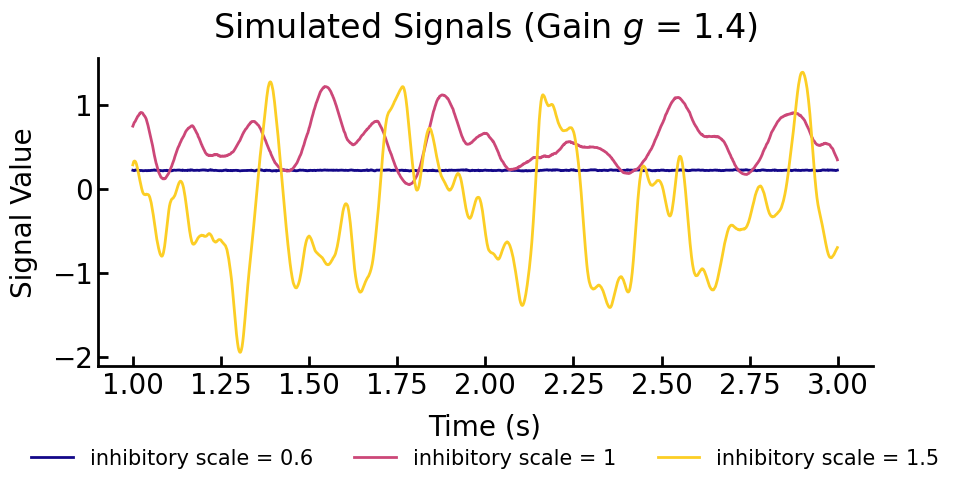

In [12]:
start = 1000
end = 3000
plt.figure(figsize=(10, 4))
cols = [cmap(0.01), cmap(0.5), cmap(0.9)]
time_vals = np.arange(start*dt, end*dt, dt)
for i, scale in enumerate(scales):
    plt.plot(time_vals, plot_sigs[i][start:end, 0], label=f'inhibitory scale = {scale}', c=cols[i])
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.title(f'Simulated Signals (Gain $g$ = {g})')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='center', ncol=3, fontsize=15)
plt.show()

In [13]:
lyap_matrices = []
for lyaps in all_lyaps:
    lyap_matrix = np.zeros((len(g_vals), len(inhibition_scales)))

    for i, g in enumerate(g_vals):
        for j, inh in enumerate(inhibition_scales):
            lyap_matrix[i][j] = lyaps[(g, inh)].mean()
    lyap_matrices.append(lyap_matrix)
lyap_matrices = np.array(lyap_matrices) # TRIALS x G_VALS x SCALES

In [14]:
pvalues_ttest = np.zeros((len(inhibition_scales), len(inhibition_scales)))
for i in range(len(inhibition_scales)):
    for j in range(i+1, len(inhibition_scales)):
        pvalues_ttest[i, j] = ttest_ind(lyap_matrices[:, :, i].flatten(), lyap_matrices[:, :, j].flatten(), alternative='less').pvalue
vmin= pvalues_ttest.min()
vmax=pvalues_ttest.max()
for i in range(len(inhibition_scales)):
    for j in range(i, len(inhibition_scales)):
        pvalues_ttest[j, i] = np.nan

cmap = plt.get_cmap('rainbow')

array([5])

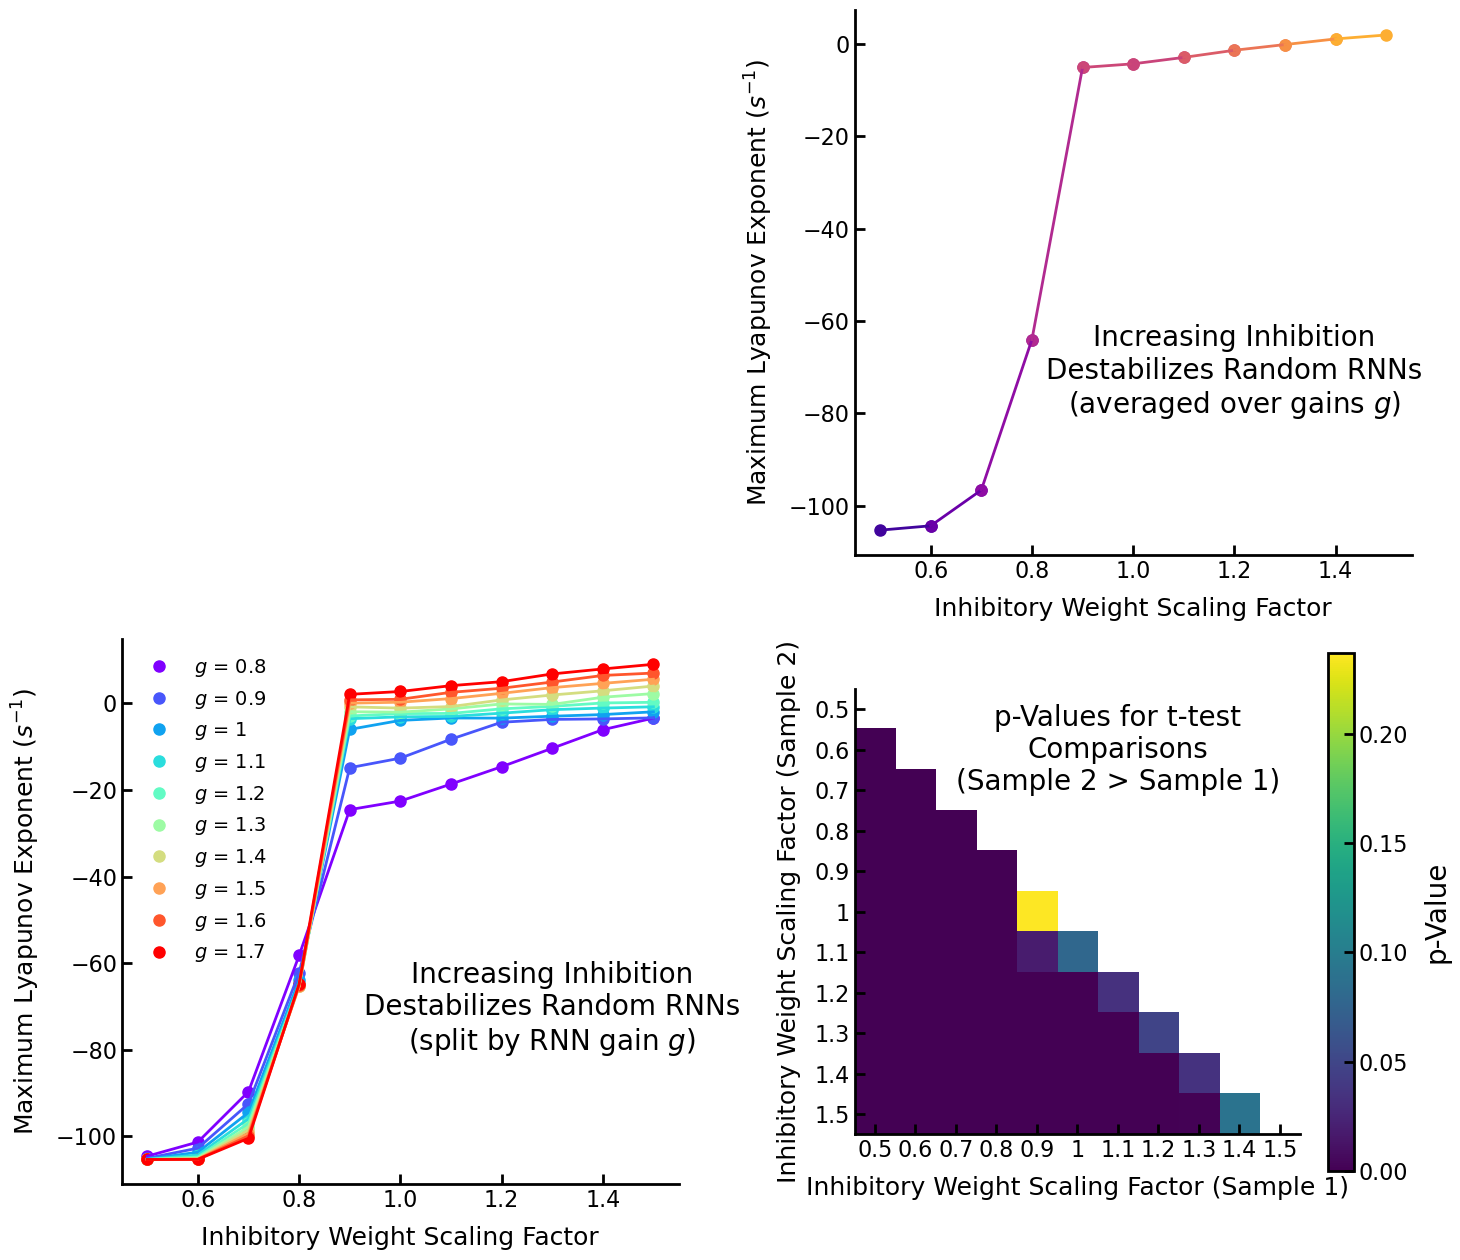

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))

title_fontsize = 20
xlabel_fontsize = 18
ylabel_fontsize = 18
ticklabel_fontsize = 16
cbar_tick_fontsize = 16
legend_fontsize=14

ax = axs[0][0]
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax = axs[0][1]
errs = lyap_matrices.std(axis=(0, 1))/(lyap_matrices.shape[0]*lyap_matrices.shape[1])

# ax.plot(inhibition_scales, lyap_matrices.mean(axis=(0, 1)), 'o', markersize=8, color='k')

# ax.errorbar(inhibition_scales, lyap_matrices.mean(axis=(0, 1)), errs, color='k')
mid_ind = np.where(np.array(inhibition_scales) == 1)[0]
for i in range(len(inhibition_scales) - 1):
    if i < mid_ind:
        c = plt.get_cmap('plasma')((i+1)/mid_ind*0.5)
    else:
        c = plt.get_cmap('plasma')((i+1)/len(inhibition_scales)*0.9)
    ax.plot(inhibition_scales[i:i+2], lyap_matrices.mean(axis=(0, 1))[i:i+2], 'o', markersize=8, color=c)
    ax.errorbar(inhibition_scales[i:i+2], lyap_matrices.mean(axis=(0, 1))[i:i+2], errs[i:i+2], color=c)    


# errs = lyap_matrices.std(axis=(0, 1))

# plt.plot(inhibition_scales, lyap_matrices[:, 5].mean(axis=0))
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('Inhibitory Weight Scaling Factor', fontsize=xlabel_fontsize)
ax.set_ylabel(r'Maximum Lyapunov Exponent ($s^{-1}$)', fontsize=ylabel_fontsize)
# ax.set_title('Increasing Inhibition Leads Destabilizes Random RNNs', fontsize=title_fontsize)
ax.tick_params(labelsize=ticklabel_fontsize)
ax.text(1.2, -80, 'Increasing Inhibition\nDestabilizes Random RNNs\n(averaged over gains $g$)', ha='center', fontsize=title_fontsize)

ax = axs[1][0]
color_vals = cmap(np.linspace(0, 1, len(g_vals)))
for i in range(len(g_vals)):
    ax.plot(inhibition_scales, lyap_matrices[:, i].mean(axis=0), 'o', markersize=8, label=f"$g$ = {g_vals[i]}", color=color_vals[i])
    ax.errorbar(inhibition_scales, lyap_matrices[:, i].mean(axis=0), yerr=lyap_matrices[:, i].std(axis=0)/lyap_matrices.shape[0], color=color_vals[i])
ax.legend(fontsize=legend_fontsize)
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('Inhibitory Weight Scaling Factor', fontsize=xlabel_fontsize)
ax.set_ylabel(r'Maximum Lyapunov Exponent ($s^{-1}$)', fontsize=ylabel_fontsize)
ax.tick_params(labelsize=ticklabel_fontsize)
# ax.set_title('Increasing Inhibition\nDestabilizes Random RNNs\n(split by RNN gain)')
ax.text(1.3, -80, 'Increasing Inhibition\nDestabilizes Random RNNs\n(split by RNN gain $g$)', ha='center', fontsize=title_fontsize)

ax = axs[1][1]
im = ax.imshow(pvalues_ttest.T)
ax.set_xticks(np.arange(len(inhibition_scales)))
ax.set_xticklabels(inhibition_scales)
ax.set_yticks(np.arange(len(inhibition_scales)))
ax.set_yticklabels(inhibition_scales)
ax.tick_params(labelsize=ticklabel_fontsize)
# ax.setyticks(np.arange(len(inhibition_scales)), inhibition_scales)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
cbar = plt.colorbar(im, ax=ax, shrink=0.95, label='p-Value')
cbar.ax.tick_params(labelsize=cbar_tick_fontsize)
# ax.set_title('p-Values for t-test Comparisons (Sample 2 > Sample 1)', fontsize=title_fontsize)
ax.set_xlabel('Inhibitory Weight Scaling Factor (Sample 1)', fontsize=xlabel_fontsize)
ax.set_ylabel('Inhibitory Weight Scaling Factor (Sample 2)', fontsize=ylabel_fontsize)
ax.text(6, 2, 'p-Values for t-test\nComparisons\n(Sample 2 > Sample 1)', ha='center', fontsize=title_fontsize)

plt.tight_layout()
plt.show()